In [1]:
from collections import Counter, OrderedDict
from pathlib import Path
import re

import matplotlib.pyplot as plt
import nltk
nltk.download('punkt_tab')
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline, AutoTokenizer, AutoModel
import torch

from nltk.corpus import opinion_lexicon, stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\vladi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
f:\anaconda3\envs\python-3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Working with Text Lab
## Information retrieval, preprocessing, and feature extraction

In this lab, you'll be looking at and exploring European restaurant reviews. The dataset is rather tiny, but that's just because it has to run on any machine. In real life, just like with images, texts can be several terabytes long.

The dataset is located [here](https://www.kaggle.com/datasets/gorororororo23/european-restaurant-reviews) and as always, it's been provided to you in the `data/` folder.

### Problem 1. Read the dataset (1 point)
Read the dataset, get acquainted with it. Ensure the data is valid before you proceed.

How many observations are there? Which country is the most represented? What time range does the dataset represent?

Is the sample balanced in terms of restaurants, i.e., do you have an equal number of reviews for each one? Most importantly, is the dataset balanced in terms of **sentiment**?

In [3]:
restaurants = pd.read_csv('./data/European Restaurant Reviews.csv')

# Convert to lowercase for easier processing and property access
restaurants.columns = restaurants.columns.str.lower().str.replace(' ', '_')

# France is the most represented country
restaurants.country.value_counts()

# The dataset represents a timeframe from April 2012 to September 2023
timeframe = restaurants.review_date.min(), restaurants.review_date.max()
timeframe

# We do not have an equal number of reviews for each restaurant, which is normal to me
grouped = restaurants.groupby('restaurant_name').size()
grouped

# The dataset is not balanced in terms of sentiment, we have 82% positive and 18% negative reviews
restaurants.sentiment.value_counts(normalize=True) * 100

# We dont have missing values, so let's split the review date into month and year
restaurants[restaurants.review_date.isna()]
restaurants[~restaurants.review_date.str.contains(' ', na=False)]

# I will also split the review_date for easier analysis
split_cols = restaurants.review_date.str.split(' ', expand=True)
restaurants['review_month'] = split_cols[0]
restaurants['review_year'] = split_cols[1].astype(int)

restaurants.drop(columns=['review_date'], inplace=True)

restaurants

,country,restaurant_name,sentiment,review_title,review,review_month,review_year
0,France,The Frog at Bercy Village,Negative,Rude manager,The manager became agressive when I said the c...,May,2024
1,France,The Frog at Bercy Village,Negative,A big disappointment,"I ordered a beef fillet ask to be done medium,...",Feb,2024
2,France,The Frog at Bercy Village,Negative,Pretty Place with Bland Food,"This is an attractive venue with welcoming, al...",Nov,2023
3,France,The Frog at Bercy Village,Negative,Great service and wine but inedible food,Sadly I used the high TripAdvisor rating too ...,Mar,2023
4,France,The Frog at Bercy Village,Negative,Avoid- Worst meal in Rome - possibly ever,From the start this meal was bad- especially g...,Nov,2022
...,...,...,...,...,...,...,...
1497,Cuba,Old Square (Plaza Vieja),Negative,The Tourism Trap,Despite the other reviews saying that this is ...,Oct,2016
1498,Cuba,Old Square (Plaza Vieja),Negative,the beer factory,beer is good. food is awfull The only decent...,Oct,2016
1499,Cuba,Old Square (Plaza Vieja),Negative,brewery,"for terrible service of a truly comedic level,...",Oct,2016
1500,Cuba,Old Square (Plaza Vieja),Negative,It's nothing exciting over there,We visited the Havana's Club Museum which is l...,Oct,2016


### Problem 2. Getting acquainted with reviews (1 point)
Are positive comments typically shorter or longer? Try to define a good, robust metric for "length" of a text; it's not necessary just the character count. Can you explain your findings?

In [4]:
# First get the negative reviews
negative_reviews = restaurants[restaurants.sentiment == 'Negative']
negative_reviews_count = len(negative_reviews)
negative_reviews_words_count = negative_reviews.review.str.split().str.len().sum()
average_negative_review_length = negative_reviews_words_count / negative_reviews_count
average_negative_review_length

# Actuallt, we can do it a lot faster...
negative_reviews.review.str.split().str.len().describe()
# Average negative review's length is 140 words

# Now the positive reviews...
positive_reviews = restaurants[restaurants.sentiment == 'Positive']
# Average positive review is 50 words
positive_reviews.review.str.split().str.len().describe()

# In order to create a robust metric for length of a text, we need to take into account that the positive reviews are usually longer because people are more expressive
# and use more words to describe their good experience. Ex: "horrible pancakes" vs "I loved the pancakes!" -> two words vs 4 words and a sign.
# So if we were to normalize the word counts, for positive reviews we would need to divide them by 2.8 (140 / 50) to get a more accurate comparison.
# Actually... I might be overthinking it, a simpler way would be to simply count the words and not the characters, since in a review, words are what matter the most.
# I already did that so there isn't much to do here.

restaurants.review.str.split().str.len().describe()

count    1502.000000
mean       66.131158
std        74.008747
min         2.000000
25%        26.000000
50%        42.500000
75%        74.000000
max       646.000000
Name: review, dtype: float64

### Problem 3. Preprocess the review content (2 points)
You'll likely need to do this while working on the problems below, but try to synthesize (and document!) your preprocessing here. Your tasks will revolve around words and their connection to sentiment. While preprocessing, keep in mind the domain (restaurant reviews) and the task (sentiment analysis).

In [5]:
# Okay, first I will synthasize the reviews, and then add them in a new column as a list of tokens

# First I will define a function that accepts a text, and tokenizes it.
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize the text
    tokens = [word for word in tokens if word not in stop_words] # Remove stop words
    return tokens

# And save the tokens in a new column
restaurants['review_tokens'] = restaurants.review.apply(preprocess_text)
restaurants

,country,restaurant_name,sentiment,review_title,review,review_month,review_year,review_tokens
0,France,The Frog at Bercy Village,Negative,Rude manager,The manager became agressive when I said the c...,May,2024,"[manager, became, agressive, said, carbonara, ..."
1,France,The Frog at Bercy Village,Negative,A big disappointment,"I ordered a beef fillet ask to be done medium,...",Feb,2024,"[ordered, beef, fillet, ask, done, medium, got..."
2,France,The Frog at Bercy Village,Negative,Pretty Place with Bland Food,"This is an attractive venue with welcoming, al...",Nov,2023,"[attractive, venue, welcoming, albeit, somewha..."
3,France,The Frog at Bercy Village,Negative,Great service and wine but inedible food,Sadly I used the high TripAdvisor rating too ...,Mar,2023,"[sadly, used, high, tripadvisor, rating, liter..."
4,France,The Frog at Bercy Village,Negative,Avoid- Worst meal in Rome - possibly ever,From the start this meal was bad- especially g...,Nov,2022,"[start, meal, bad, especially, given, price, v..."
...,...,...,...,...,...,...,...,...
1497,Cuba,Old Square (Plaza Vieja),Negative,The Tourism Trap,Despite the other reviews saying that this is ...,Oct,2016,"[despite, reviews, saying, lovely, place, hang..."
1498,Cuba,Old Square (Plaza Vieja),Negative,the beer factory,beer is good. food is awfull The only decent...,Oct,2016,"[beer, good, food, awfull, decent, thing, shis..."
1499,Cuba,Old Square (Plaza Vieja),Negative,brewery,"for terrible service of a truly comedic level,...",Oct,2016,"[terrible, service, truly, comedic, level, 23,..."
1500,Cuba,Old Square (Plaza Vieja),Negative,It's nothing exciting over there,We visited the Havana's Club Museum which is l...,Oct,2016,"[visited, havanas, club, museum, located, old,..."


### Problem 4. Top words (1 point)
Use a simple word tokenization and count the top 10 words in positive reviews; then the top 10 words in negative reviews*. Once again, try to define what "top" words means. Describe and document your process. Explain your results.

\* Okay, you may want to see top N words (with $N \ge 10$).

In [6]:
# In order to defind "top" words we would need some soft of scale.
# nltk seems to have an opinion_lexicon that contains positive and negative words.

opinion_lexicon.positive()
opinion_lexicon.negative()

# But I don't think "top" means the frequency of words, but rather the most relevant ones.
# nltk seems to have a sentiment intensity analyzer that can help us with that.
sia = SentimentIntensityAnalyzer()

sia.lexicon['love'], sia.lexicon['shit']
# Okay, this works really well :D

negative_reviews = restaurants[restaurants.sentiment == 'Negative']
positive_reviews = restaurants[restaurants.sentiment == 'Positive']

# I would create two new columns and save the top 10 words for the respective sentiment, but I feel like simply listing the top 10 for all positive/negative would be better and more interesting.
def get_top_n_reviews(n, positive):
    if n >= 10:
        n
    else:
        n = 10

    all_tokens = []

    if positive:
        for review in positive_reviews.review_tokens:
            for token in review:
                all_tokens.append(token)
    else:
        for review in negative_reviews.review_tokens:
            for token in review:
                all_tokens.append(token)

    # Create a dictionary of token -> score using get to avoid KeyError
    token_scores = {token: sia.lexicon.get(token, 0) for token in all_tokens}

    # Sort by score
    sorted_tokens = sorted(token_scores.items(), key=lambda x: x[1], reverse=positive)

    # Get top n as an OrderedDict (optional, for keeping order)
    top_n_dict = OrderedDict(sorted_tokens[:n])

    return top_n_dict

top_10_positive_words = get_top_n_reviews(10, True)
top_10_negative_words = get_top_n_reviews(10, False)

# And here we go...
top_10_positive_words , top_10_negative_words

(OrderedDict([('sweetheart', 3.3),
              ('love', 3.2),
              ('best', 3.2),
              ('perfectly', 3.2),
              ('greatest', 3.2),
              ('great', 3.1),
              ('superb', 3.1),
              ('awesome', 3.1),
              ('excellently', 3.1),
              ('masterpiece', 3.1)]),
 OrderedDict([('killed', -3.5),
              ('dead', -3.3),
              ('pissed', -3.2),
              ('worst', -3.1),
              ('disaster', -3.1),
              ('vile', -3.1),
              ('dismal', -3.0),
              ('war', -2.9),
              ('cruel', -2.8),
              ('ruin', -2.8)]))

In [7]:
# Adding top n good and bad words to the dataframe
def get_top_words(tokens, n):
    # Create a dictionary of token -> score
    token_scores = {token: sia.lexicon.get(token, 0) for token in tokens}

    # Separate positive and negative tokens
    positive_tokens = {token: score for token, score in token_scores.items() if score > 0}
    negative_tokens = {token: score for token, score in token_scores.items() if score < 0}

    # Sort and get top N
    top_pos = sorted(positive_tokens.items(), key=lambda x: x[1], reverse=True)[:n]
    top_neg = sorted(negative_tokens.items(), key=lambda x: x[1])[:n]  # ascending for negative values

    return (
        [token for token, score in top_pos],  # list of top positive words
        [token for token, score in top_neg],  # list of top negative words
    )

# Apply to each row
restaurants[['top_positive_words', 'top_negative_words']] = restaurants.review_tokens.apply(
    lambda tokens: pd.Series(get_top_words(tokens, n=10))
)

restaurants


,country,restaurant_name,sentiment,review_title,review,review_month,review_year,review_tokens,top_positive_words,top_negative_words
0,France,The Frog at Bercy Village,Negative,Rude manager,The manager became agressive when I said the c...,May,2024,"[manager, became, agressive, said, carbonara, ...",[good],"[worst, bad, rude]"
1,France,The Frog at Bercy Village,Negative,A big disappointment,"I ordered a beef fillet ask to be done medium,...",Feb,2024,"[ordered, beef, fillet, ask, done, medium, got...",[well],"[fool, charged]"
2,France,The Frog at Bercy Village,Negative,Pretty Place with Bland Food,"This is an attractive venue with welcoming, al...",Nov,2023,"[attractive, venue, welcoming, albeit, somewha...","[lovely, attractive, welcoming]",[]
3,France,The Frog at Bercy Village,Negative,Great service and wine but inedible food,Sadly I used the high TripAdvisor rating too ...,Mar,2023,"[sadly, used, high, tripadvisor, rating, liter...","[best, great, amazing, justice, friendly, enjo...","[failed, disappointed, poor, sadly, mistake, o..."
4,France,The Frog at Bercy Village,Negative,Avoid- Worst meal in Rome - possibly ever,From the start this meal was bad- especially g...,Nov,2022,"[start, meal, bad, especially, given, price, v...","[best, good, better, forgiven, ok, well, recom...","[worst, bad, wrong, avoid, strange, weird, hard]"
...,...,...,...,...,...,...,...,...,...,...
1497,Cuba,Old Square (Plaza Vieja),Negative,The Tourism Trap,Despite the other reviews saying that this is ...,Oct,2016,"[despite, reviews, saying, lovely, place, hang...","[lovely, beauty, charm, natural, giving]",[]
1498,Cuba,Old Square (Plaza Vieja),Negative,the beer factory,beer is good. food is awfull The only decent...,Oct,2016,"[beer, good, food, awfull, decent, thing, shis...",[good],[]
1499,Cuba,Old Square (Plaza Vieja),Negative,brewery,"for terrible service of a truly comedic level,...",Oct,2016,"[terrible, service, truly, comedic, level, 23,...","[truly, comedic]","[terrible, fault]"
1500,Cuba,Old Square (Plaza Vieja),Negative,It's nothing exciting over there,We visited the Havana's Club Museum which is l...,Oct,2016,"[visited, havanas, club, museum, located, old,...","[fun, impressed, nice]",[]


### Problem 5. Review titles (2 point)
How do the top words you found in the last problem correlate to the review titles? Do the top 10 words (for each sentiment) appear in the titles at all? Do reviews which contain one or more of the top words have the same words in their titles?

Does the title of a comment present a good summary of its content? That is, are the titles descriptive, or are they simply meant to catch the attention of the reader?

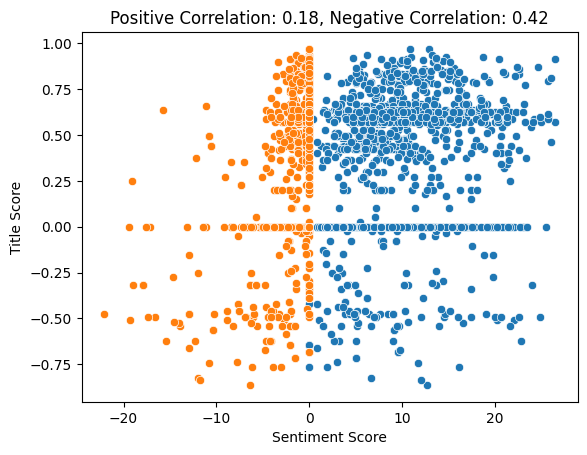

In [8]:
# How do the top words you found in the last problem correlate to the review titles?
# Okay seems like I misunderstood the previous task... I will go back and add two new columns to hold the top 10 good and bad words
negative_reviews = restaurants[restaurants.sentiment == 'Negative']
positive_reviews = restaurants[restaurants.sentiment == 'Positive']

# Let's calculate the correlation between the sentiment value of the words and visualize it.
def sentiment_score(tokens):
    return sum([sia.lexicon.get(token, 0) for token in tokens])

restaurants['positive_score'] = restaurants.top_positive_words.apply(sentiment_score)
restaurants['negative_score'] = restaurants.top_negative_words.apply(sentiment_score)

restaurants['title_score'] = restaurants.review_title.apply(lambda x: sia.polarity_scores(x)['compound'])

positive_correlation = restaurants.positive_score.corr(restaurants.title_score)
negative_correlation = restaurants.negative_score.corr(restaurants.title_score)

sns.scatterplot(data=restaurants, x='positive_score', y='title_score')
sns.scatterplot(data=restaurants, x='negative_score', y='title_score')
plt.title(f'Positive Correlation: {positive_correlation:.2f}, Negative Correlation: {negative_correlation:.2f}')
plt.xlabel('Sentiment Score')
plt.ylabel('Title Score')
plt.show()


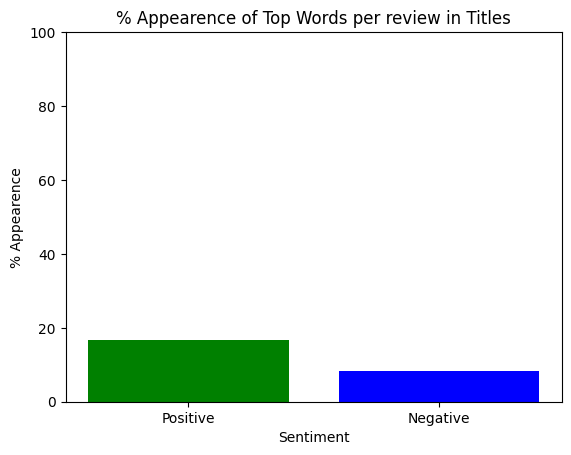

In [9]:
# Do the top 10 words (for each sentiment) appear in the titles at all?
# Let's see if the top 10 words appear in the titles.
def plot_top_words_appearence_in_title(title):
    positive_reviews_appearences = 0
    negative_reviews_appearences = 0

    for _, review in restaurants.iterrows():
        if review.sentiment == 'Positive':
            for word in review.top_positive_words:
                if word in review.review_title:
                    positive_reviews_appearences += 1
        if review.sentiment == 'Negative':
            for word in review.top_negative_words:
                if word in review.review_title:
                    negative_reviews_appearences += 1

    positive_appearence = (positive_reviews_appearences / len(positive_reviews)) * 100
    negative_appearence = (negative_reviews_appearences / len(negative_reviews)) * 100

    plt.bar(['Positive', 'Negative'], [positive_appearence, negative_appearence], color=['green', 'blue'])
    plt.ylim(0, 100)
    plt.title(title)
    plt.xlabel('Sentiment')
    plt.ylabel('% Appearence')
    plt.show()

plot_top_words_appearence_in_title(title='% Appearence of Top Words per review in Titles')

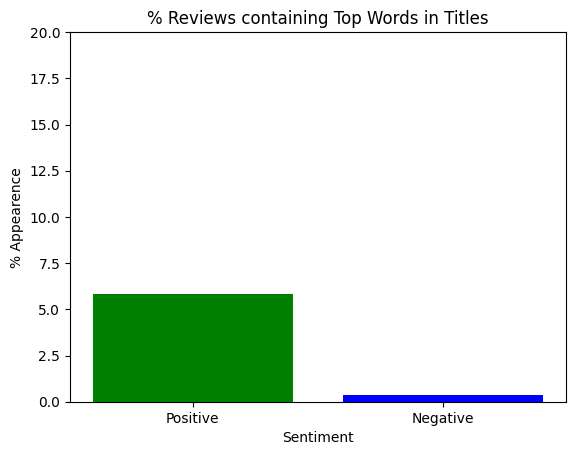

In [10]:
# Do reviews which contain one or more of the top words have the same words in their titles?
# Okay seems like I started correctly in the beginning by simply getting the top words for a sentiment, then I added them for each review...
# Whatever, lets continue.
top_positive_set = set(top_10_positive_words.keys())
top_negative_set = set(top_10_negative_words.keys())

reviews_containing_top_positive_words = positive_reviews[positive_reviews.review_tokens.apply(lambda tokens: any(token in top_positive_set for token in tokens))]
reviews_containing_top_negative_words = negative_reviews[negative_reviews.review_tokens.apply(lambda tokens: any(token in top_negative_set for token in tokens))]

reviews_with_titles_containing_top_positive = reviews_containing_top_positive_words[reviews_containing_top_positive_words.review_title.apply(lambda title: any(token in title for token in top_positive_set))]
reviews_with_titles_containing_top_negative = reviews_containing_top_negative_words[reviews_containing_top_negative_words.review_title.apply(lambda title: any(token in title for token in top_negative_set))]

len(reviews_with_titles_containing_top_positive), len(reviews_with_titles_containing_top_negative)

# We see that in 72 positive reviews the top words are contained in the title, and only 1 from the negative reviews.
# Let's get the percentage and plot it.
percentage_positive = (len(reviews_with_titles_containing_top_positive) / len(positive_reviews)) * 100
percentage_negative = (len(reviews_with_titles_containing_top_negative) / len(negative_reviews)) * 100

percentage_positive, percentage_negative

plt.bar(['Positive', 'Negative'], [percentage_positive, percentage_negative], color=['green', 'blue'])
plt.ylim(0, 20)
plt.title('% Reviews containing Top Words in Titles')
plt.xlabel('Sentiment')
plt.ylabel('% Appearence')
plt.show()

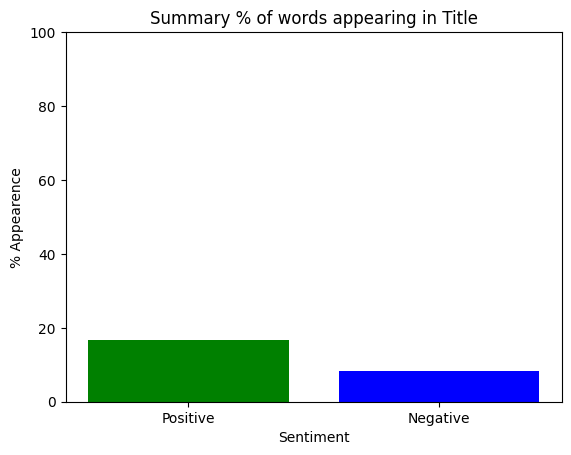

In [11]:
# Does the title of a comment present a good summary of its content? That is, are the titles descriptive, or are they simply meant to catch the attention of the reader?
# I feel like that's what I covered in cell 2 of this task where I calculated the percecntage of top words per review in titles.
# Most reviews don't even have more than 10 sentiment evaluated words so I would say it's pretty accurate.
# But just for save measures I will add 30 top words per review and plot again.
# I will first go back and extract the logic in a function which I can reuse.
# And now...

restaurants[['top_positive_words', 'top_negative_words']] = restaurants.review_tokens.apply(
    lambda tokens: pd.Series(get_top_words(tokens, n=30))
)
plot_top_words_appearence_in_title(title='Summary % of words appearing in Title')

### Problem 6. Bag of words (1 point)
Based on your findings so far, come up with a good set of settings (hyperparameters) for a bag-of-words model for review titles and contents. It's easiest to treat them separately (so, create two models); but you may also think about a unified representation. I find the simplest way of concatenating the title and content too simplistic to be useful, as it doesn't allow you to treat the title differently (e.g., by giving it more weight).

The documentation for `CountVectorizer` is [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Familiarize yourself with all settings; try out different combinations and come up with a final model; or rather - two models :).

In [12]:
# Title model

# I will use analyzer='words' since we are interested in the words in the title, not the characters.
# I will also use stop_words
# I will use strip_accents='unicode' to remove the accents from the words, since they are not important for the analysis.
vectorizer = CountVectorizer(analyzer='word',
                             stop_words='english',
                             lowercase=True,
                             strip_accents='unicode',
                             max_df=0.95,  # Ignore words that appear in more than 95% of the documents
                             min_df=5,  # Ignore words that appear in less than 2 documents
                             ngram_range=(1, 1))  # Unigrams only
X = vectorizer.fit_transform(restaurants.review_title)
ordered_volcabulary = dict(sorted(vectorizer.vocabulary_.items(), key=lambda x: x[1], reverse=True))
ordered_volcabulary

# Just experimenting with the vectorizer:

# X is a 2D sparce array, it tells us the features that appear in the document number 200. We see that in index 17 we have a '1', which means feature number 17 appears in the document number 200.
# The feature number 17 is 'traditional'.
X[200].toarray().flatten()

list(ordered_volcabulary.keys())[17]  # this will give you the value at index 1
# So the matrix generated by vectorizer has n rows (number of documents) and m cols (number of features). PS: features are unique ofc.
# Every time a feature is found in a document, we set the value +1 depending on how many times it appears.


'traditional'

In [13]:
# Review model

# Okay, for the reviews model, I will use analyzer='word' so we make the features of words.
# I will use ngram range of (1, 2) so we use unigrams and bigrams since we have longer text here, and we might be missing meaning if we only use single words.
# I will also use stopwords='english' to remove common words that don't add much meaning.
# I will use lowercase=True to recude the vocabulary and make everything be treated as the same token.
# I thought about using max_features but we have about 1.5k reviews which means a lot of terminology... Actually, since we have a lot of reviews, I will limit it. Let's say to 5k features.
# since words can be repeated.
# I will use strup_accents='unicode' to strip accents...
vectorizer2 = CountVectorizer(analyzer='word', 
                              ngram_range=(1, 2), 
                              stop_words='english', 
                              lowercase=True, 
                              min_df=0.05,
                              max_features=5000,
                              strip_accents='unicode')
X2 = vectorizer2.fit_transform(restaurants.review)
vectorizer.vocabulary_
ordered_vocabulary2 = dict(sorted(vectorizer.vocabulary_.items(), key=lambda x: x[1], reverse=True))
ordered_vocabulary2 # not sure why strip_accents is not working, it did a couple of times while testing...

# Just checking if we actually have bigrams, since some parameters seemed not to work.
vocab = vectorizer2.get_feature_names_out()

bigrams = [word for word in vocab if len(word.split()) == 2]
bigrams

['ad hoc', 'highly recommend', 'tasting menu']

### Problem 7. Deep sentiment analysis models (1 point)
Find a suitable model for sentiment analysis in English. Without modifying, training, or fine-tuning the model, make it predict all contents (or better, combinations of titles and contents, if you can). Meaure the accuracy of the model compared to the `sentiment` column in the dataset.

In [14]:
# Initializing the pipeline with default model
sentiment_pipeline = pipeline("sentiment-analysis")

sentiment_scores = []
# For later visualization
predicted_values = []
actual_values = []

for i, review in restaurants.iterrows():
    label = sentiment_pipeline(f'{review.review_title}, {review.review}'[:1000])[0]['label'] # Make a prediction on the title and review text combined.

    predicted_value = label.lower()
    actual_value = review.sentiment.lower()
    predicted_values.append(predicted_value)
    actual_values.append(actual_value)

    sentiment_scores.append(f'Index: {i}, Predicted: {predicted_value}, Actual: {actual_value}')

# Quickly checking it out it seems very good, lets try to  visualize it.
sentiment_scores

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


['Index: 0, Predicted: negative, Actual: negative',
 'Index: 1, Predicted: negative, Actual: negative',
 'Index: 2, Predicted: negative, Actual: negative',
 'Index: 3, Predicted: negative, Actual: negative',
 'Index: 4, Predicted: negative, Actual: negative',
 'Index: 5, Predicted: negative, Actual: negative',
 'Index: 6, Predicted: negative, Actual: negative',
 'Index: 7, Predicted: negative, Actual: negative',
 'Index: 8, Predicted: negative, Actual: negative',
 'Index: 9, Predicted: negative, Actual: negative',
 'Index: 10, Predicted: negative, Actual: negative',
 'Index: 11, Predicted: negative, Actual: negative',
 'Index: 12, Predicted: negative, Actual: negative',
 'Index: 13, Predicted: negative, Actual: negative',
 'Index: 14, Predicted: positive, Actual: negative',
 'Index: 15, Predicted: negative, Actual: negative',
 'Index: 16, Predicted: negative, Actual: negative',
 'Index: 17, Predicted: negative, Actual: negative',
 'Index: 18, Predicted: negative, Actual: negative',
 'I

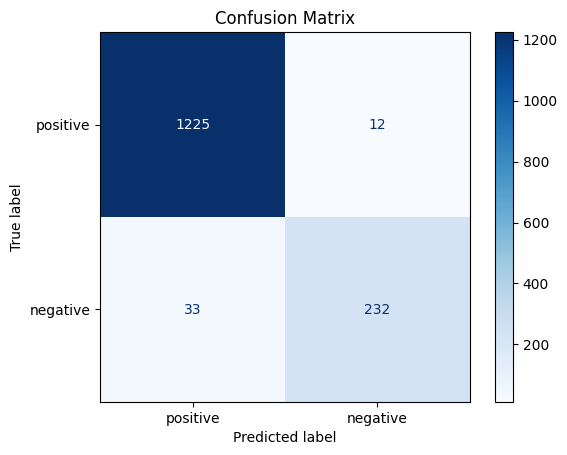

In [15]:
# Visualizing it with a cocnfusion matrix.
cm = confusion_matrix(actual_values, predicted_values, labels=['positive', 'negative'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['positive', 'negative'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

### Problem 8. Deep features (embeddings) (1 point)
Use the same model to perform feature extraction on the review contents (or contents + titles) instead of direct predictions. You should already be familiar how to do that from your work on images.

Use the cosine similarity between texts to try to cluster them. Are there "similar" reviews (you'll need to find a way to measure similarity) across different restaurants? Are customers generally in agreement for the same restaurant?

In [ ]:
# Get the model name
model_name = sentiment_pipeline.model.name_or_path
# Get the tokenizer and base model components
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Combine title and review text for embedding generation
texts = (restaurants.review_title + ' ' + restaurants.review).tolist()  # Combine title and review text

# Function to get embeddings for a list of texts
def get_embeddings(texts, batch_size=32):
    embeddings = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        
        # Tokenize the batch
        inputs = tokenizer(batch, return_tensors="pt", 
                          padding=True, truncation=True, 
                          max_length=512)
        
        # Get embeddings (no gradient needed) and contextualize the input
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Use mean pooling of last hidden states
        last_hidden_states = outputs.last_hidden_state
        # Pool the token embeddings to flatten to the token dimension (batch_size, sequence_length)
        batch_embeddings = last_hidden_states.mean(dim=1).numpy()
        embeddings.extend(batch_embeddings)
    
    return np.array(embeddings)

# Get embeddings for all reviews
review_embeddings = get_embeddings(texts)

# Compute pairwise cosine similarities
similarity_matrix = cosine_similarity(review_embeddings)

# And now we have the simularity matrix, where each index is a review index, meaning diagonal is 1 (self-similarity)
similarity_matrix

array([[1.0000002 , 0.6953261 , 0.3324937 , ..., 0.6704397 , 0.27353734,
        0.8644155 ],
       [0.6953261 , 0.9999999 , 0.69183517, ..., 0.86945605, 0.57453114,
        0.8184893 ],
       [0.3324937 , 0.69183517, 0.99999994, ..., 0.61321795, 0.8078313 ,
        0.4840256 ],
       ...,
       [0.6704397 , 0.86945605, 0.61321795, ..., 0.99999994, 0.5037947 ,
        0.82165253],
       [0.27353734, 0.57453114, 0.8078313 , ..., 0.5037947 , 0.9999998 ,
        0.38599452],
       [0.8644155 , 0.8184893 , 0.4840256 , ..., 0.82165253, 0.38599452,
        0.9999999 ]], dtype=float32)

In [ ]:
# Now I will create a DataFrame displaying the review titles for easier comparison
similarity_df = pd.DataFrame(similarity_matrix, 
                            index=restaurants.review_title,
                            columns=restaurants.review_title)

similarity_df

review_title,Rude manager,A big disappointment,Pretty Place with Bland Food,Great service and wine but inedible food,Avoid- Worst meal in Rome - possibly ever,"Shocking management, TERRIBLE service by mum and daughter!! FOR Tourist ONLY!!",We tired the tasting menu - avoid,Huge Disappointment,Expensive mediocre food and service,all around awful,...,It's nothing exciting over there,Tourist Trap,"Over-renovated, or in a state of transition?","The square is beautiful, but that's it.",Great place to watch Cuba go by,The Tourism Trap,the beer factory,brewery,It's nothing exciting over there,Tourist Trap
review_title,,,,,,,,,,,,,,,,,,,,,
Rude manager,1.000000,0.695326,0.332494,0.716873,0.840274,0.786687,0.929970,0.894421,0.886430,0.862702,...,0.273537,0.864416,0.817701,0.238165,-0.420184,0.409792,0.707784,0.670440,0.273537,0.864416
A big disappointment,0.695326,1.000000,0.691835,0.860105,0.890049,0.862954,0.775261,0.867150,0.857933,0.896908,...,0.574531,0.818489,0.829396,0.504963,-0.193241,0.681338,0.891838,0.869456,0.574531,0.818489
Pretty Place with Bland Food,0.332494,0.691835,1.000000,0.755811,0.590781,0.665981,0.442582,0.559660,0.538822,0.600257,...,0.807831,0.484026,0.636236,0.784104,0.355248,0.799696,0.650447,0.613218,0.807831,0.484026
Great service and wine but inedible food,0.716873,0.860105,0.755811,1.000000,0.920767,0.944400,0.793180,0.878366,0.854812,0.916518,...,0.704709,0.786153,0.884521,0.613132,-0.034844,0.823156,0.837840,0.818752,0.704709,0.786153
Avoid- Worst meal in Rome - possibly ever,0.840274,0.890049,0.590781,0.920767,1.000000,0.932938,0.900022,0.956493,0.950383,0.962586,...,0.507713,0.903477,0.905439,0.434014,-0.320285,0.654997,0.884184,0.869009,0.507713,0.903477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
The Tourism Trap,0.409792,0.681338,0.799696,0.823156,0.654997,0.772020,0.492643,0.612450,0.583151,0.676273,...,0.837926,0.521704,0.735910,0.798336,0.308851,1.000000,0.690161,0.655748,0.837926,0.521704
the beer factory,0.707784,0.891838,0.650447,0.837840,0.884184,0.843950,0.763546,0.873590,0.863425,0.873399,...,0.547004,0.858014,0.838584,0.538250,-0.209031,0.690161,1.000000,0.867595,0.547004,0.858014
brewery,0.670440,0.869456,0.613218,0.818752,0.869009,0.840196,0.744096,0.842292,0.849557,0.848037,...,0.503795,0.821653,0.793795,0.475294,-0.249248,0.655748,0.867595,1.000000,0.503795,0.821653


In [34]:
restaurants

,country,restaurant_name,sentiment,review_title,review,review_month,review_year,review_tokens,top_positive_words,top_negative_words,positive_score,negative_score,title_score
0,France,The Frog at Bercy Village,Negative,Rude manager,The manager became agressive when I said the c...,May,2024,"[manager, became, agressive, said, carbonara, ...",[good],"[worst, bad, rude]",1.9,-7.6,-0.4588
1,France,The Frog at Bercy Village,Negative,A big disappointment,"I ordered a beef fillet ask to be done medium,...",Feb,2024,"[ordered, beef, fillet, ask, done, medium, got...",[well],"[fool, charged]",1.1,-2.7,-0.5106
2,France,The Frog at Bercy Village,Negative,Pretty Place with Bland Food,"This is an attractive venue with welcoming, al...",Nov,2023,"[attractive, venue, welcoming, albeit, somewha...","[lovely, attractive, welcoming]",[],6.6,0.0,0.4939
3,France,The Frog at Bercy Village,Negative,Great service and wine but inedible food,Sadly I used the high TripAdvisor rating too ...,Mar,2023,"[sadly, used, high, tripadvisor, rating, liter...","[best, great, amazing, justice, friendly, enjo...","[failed, disappointed, poor, sadly, mistake, o...",23.4,-12.2,0.3716
4,France,The Frog at Bercy Village,Negative,Avoid- Worst meal in Rome - possibly ever,From the start this meal was bad- especially g...,Nov,2022,"[start, meal, bad, especially, given, price, v...","[best, good, better, forgiven, ok, well, recom...","[worst, bad, wrong, avoid, strange, weird, hard]",11.7,-10.8,-0.7430
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1497,Cuba,Old Square (Plaza Vieja),Negative,The Tourism Trap,Despite the other reviews saying that this is ...,Oct,2016,"[despite, reviews, saying, lovely, place, hang...","[lovely, beauty, charm, natural, giving]",[],10.2,0.0,-0.3182
1498,Cuba,Old Square (Plaza Vieja),Negative,the beer factory,beer is good. food is awfull The only decent...,Oct,2016,"[beer, good, food, awfull, decent, thing, shis...",[good],[],1.9,0.0,0.0000
1499,Cuba,Old Square (Plaza Vieja),Negative,brewery,"for terrible service of a truly comedic level,...",Oct,2016,"[terrible, service, truly, comedic, level, 23,...","[truly, comedic]","[terrible, fault]",3.6,-3.8,0.0000
1500,Cuba,Old Square (Plaza Vieja),Negative,It's nothing exciting over there,We visited the Havana's Club Museum which is l...,Oct,2016,"[visited, havanas, club, museum, located, old,...","[fun, impressed, nice]",[],6.2,0.0,-0.3875


### \* Problem 9. Explore and model at will
In this lab, we focused on preprocessing and feature extraction and we didn't really have a chance to train (or compare) models. The dataset is maybe too small to be conclusive, but feel free to play around with ready-made models, and train your own.